In [1]:
import sys
sys.path.append('../_amigocloud')

In [2]:
import simplekml

In [4]:
from amigocloud import AmigoCloud
import pandas as pd
from shapely import wkb

import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
#from shapely.geometry import Point, MultiPoint
import os
#from fastkml import kml

In [5]:
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]

In [6]:
# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

# ACTUALIZAR SHP PLANIFICACION

In [112]:
semana = 32

In [113]:
# leer los dos shps de siembra y puntos de planificacion
path_siembras = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\SIEMBRAS.shp'
path_cat = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\catastro140624.shp'
path_puntos = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PUNTOS_PLAN.shp'

gdf_siembras = gpd.read_file(path_siembras)
gdf_puntos = gpd.read_file(path_puntos)
gdf_cat = gpd.read_file(path_cat)

In [114]:
# verifica si ambos shps tienen el mismo CRS
if gdf_siembras.crs == gdf_puntos.crs:
    print('Ambas capas tienen el mismo CRS')
else:
    print('No tienen el mismo CRS')

Ambas capas tienen el mismo CRS


<Axes: >

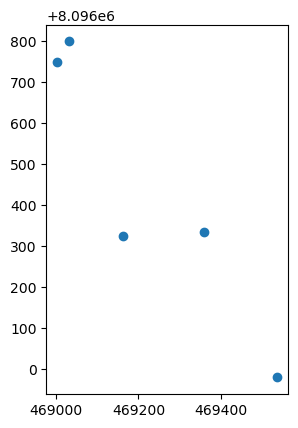

In [115]:
# filtrar la semna de interes
gdf_puntos_sem = gdf_puntos[gdf_puntos['os'] == semana]
gdf_puntos_sem.plot()

In [116]:
gdf_puntos_sem

,unidad_03,unidad_04,os,dia,geometry
6,1171,BALCAZAR BALCAZAR ROQUE DAVID\r\n,32,0,"MULTIPOINT (469538.373 8095980.150, 469161.438..."


In [117]:
path_puntos = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PUNTOS_PLAN.shp'
multipoint_gdf = gdf_puntos_sem

In [118]:
# Crear una lista para almacenar los nuevos registros de puntos individuales
point_records = []
# Iterar sobre cada registro en el GeoDataFrame original
for idx, row in multipoint_gdf.iterrows():
    multipoint_geom = row.geometry
    # Verificar si la geometría es de tipo multipunto
    if isinstance(multipoint_geom, MultiPoint):
        for point in multipoint_geom.geoms:
            # Crear un nuevo registro para cada punto individual
            new_record = row.copy()
            new_record.geometry = point
            point_records.append(new_record)
    else:
        # Si la geometría ya es un punto, simplemente añadir el registro original
        point_records.append(row)

# Crear un nuevo GeoDataFrame con los registros de puntos individuales
puntos_indi = gpd.GeoDataFrame(point_records, crs=multipoint_gdf.crs)

In [119]:
# puntos individuales
puntos_indi

,unidad_03,unidad_04,os,dia,geometry
6,1171,BALCAZAR BALCAZAR ROQUE DAVID\r\n,32,0,POINT (469538.373 8095980.150)
6,1171,BALCAZAR BALCAZAR ROQUE DAVID\r\n,32,0,POINT (469161.438 8096324.959)
6,1171,BALCAZAR BALCAZAR ROQUE DAVID\r\n,32,0,POINT (469002.526 8096748.754)
6,1171,BALCAZAR BALCAZAR ROQUE DAVID\r\n,32,0,POINT (469031.310 8096798.098)
6,1171,BALCAZAR BALCAZAR ROQUE DAVID\r\n,32,0,POINT (469360.271 8096334.811)


<Axes: >

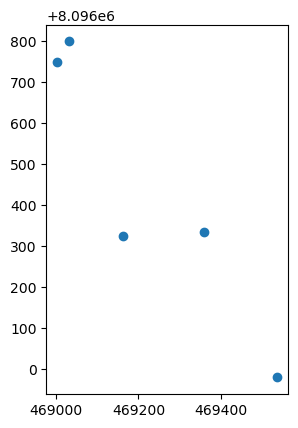

In [120]:
puntos_indi.plot()

In [121]:
# Asegurarse de que ambos GeoDataFrames tienen el mismo sistema de coordenadas (CRS)
if puntos_indi.crs != gdf_siembras.crs:
    print('Los CRS no son iguales')
    #gdf_siembras = gdf_siembras.to_crs(puntos_indi.crs)
else:
    print('Los CRS si son iguales')

Los CRS si son iguales


In [122]:
# Crear un GeoDataFrame vacío para almacenar los puntos que no intersectan con ningún polígono
puntos_indi_solicitado = puntos_indi[~puntos_indi.geometry.apply(lambda point: any(gdf_siembras.contains(point)))]

In [123]:
puntos_indi_solicitado

,unidad_03,unidad_04,os,dia,geometry
6,1171,BALCAZAR BALCAZAR ROQUE DAVID\r\n,32,0,POINT (469002.526 8096748.754)


In [124]:
# identifoca los lotes que se intersectan
gdf_lotes_cat = gpd.sjoin(gdf_cat, puntos_indi_solicitado, how='inner', predicate='intersects')

In [125]:
# filtra los lotes intersectados en la capa original
poligonos_intersect_cat = gdf_cat.loc[gdf_cat.index.isin(gdf_lotes_cat.index)]

In [126]:
# copy
poligonos_intersect_cat = poligonos_intersect_cat.copy()

In [127]:
poligonos_intersect_cat = poligonos_intersect_cat[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'geometry']]

In [128]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,geometry
9340,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L5.1,1.26,"POLYGON ((468958.101 8096856.431, 468959.680 8..."


In [129]:
# CAMBIAR NOMBRE DATOS DE UNIDAD_03 Y UNDIAD_04 DE LOTES SOLICITADOS A LO INDICADO EN LOS PUNTOS
# Iterar sobre cada punto y encontrar el polígono que intersecta
for idx, point in puntos_indi_solicitado.iterrows():
    point_geom = point.geometry
    matching_polygons = poligonos_intersect_cat[poligonos_intersect_cat.intersects(point_geom)]
    
    # Actualizar los campos de los polígonos que intersectan con los valores del punto
    for poly_idx in matching_polygons.index:
        poligonos_intersect_cat.at[poly_idx, 'unidad_03'] = point['unidad_03']
        poligonos_intersect_cat.at[poly_idx, 'unidad_04'] = point['unidad_04']

In [130]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,geometry
9340,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID\r\n,L5.1,1.26,"POLYGON ((468958.101 8096856.431, 468959.680 8..."


In [131]:
poligonos_intersect_cat['sem_reg'] = 0
poligonos_intersect_cat['fecha_ini'] = ''
poligonos_intersect_cat['origen'] = 'SOLICITUD'
poligonos_intersect_cat['dias'] = 0
poligonos_intersect_cat['fecha'] = ''
poligonos_intersect_cat['sem_plan'] = semana

In [132]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,geometry,sem_reg,fecha_ini,origen,dias,fecha,sem_plan
9340,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID\r\n,L5.1,1.26,"POLYGON ((468958.101 8096856.431, 468959.680 8...",0,,SOLICITUD,0,,32


In [133]:
# SELECCIONAR LOS LOTES DE SIEMBRAS
# identifoca los lotes que se intersectan
gdf_lotes_siem = gpd.sjoin(gdf_siembras, multipoint_gdf, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_siem = gdf_siembras.loc[gdf_siembras.index.isin(gdf_lotes_siem.index)]
# copy
poligonos_intersect_siem = poligonos_intersect_siem.copy()
# agregar campo de semana_planificacion
poligonos_intersect_siem['sem_plan'] = semana

In [134]:
poligonos_intersect_siem

,sem_reg,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,fecha_ini,origen,dias,fecha,prioridad,geometry,sem_plan
313,0.0,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L2.1,11.556979,None,SIEMBRA 2023,0,None,13,"POLYGON ((469150.275 8096553.954, 469423.512 8...",32
465,0.0,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L5.1,0.839625,None,SIEMBRA 2023,0,None,13,"POLYGON ((469093.386 8096705.068, 469059.765 8...",32
576,25.0,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L6.4,1.365556,2024-04-25,SIEMBRA 2024,63,2024-04-25,6,"POLYGON ((469569.170 8096038.910, 469570.955 8...",32
593,25.0,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L3,2.902202,2024-04-29,SIEMBRA 2024,59,2024-04-29,13,"POLYGON ((469256.883 8096164.412, 469189.404 8...",32


In [135]:
# Concatenar los DataFrames a lo largo de las filas (axis=0)
plan = pd.concat([poligonos_intersect_cat, poligonos_intersect_siem], axis=0)
# Si deseas restablecer el índice después de concatenar
plan.reset_index(drop=True, inplace=True)

<Axes: >

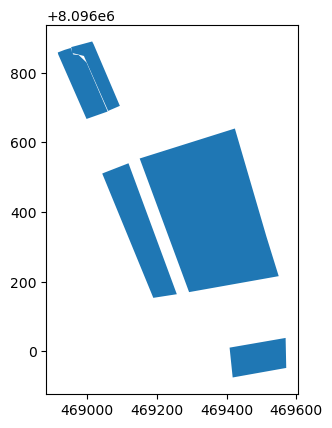

In [136]:
plan.plot()

In [137]:
plan

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,geometry,sem_reg,fecha_ini,origen,dias,fecha,sem_plan,prioridad
0,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID\r\n,L5.1,1.260000,"POLYGON ((468958.101 8096856.431, 468959.680 8...",0.0,,SOLICITUD,0,,32,NaN
1,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L2.1,11.556979,"POLYGON ((469150.275 8096553.954, 469423.512 8...",0.0,None,SIEMBRA 2023,0,None,32,13.0
2,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L5.1,0.839625,"POLYGON ((469093.386 8096705.068, 469059.765 8...",0.0,None,SIEMBRA 2023,0,None,32,13.0
3,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L6.4,1.365556,"POLYGON ((469569.170 8096038.910, 469570.955 8...",25.0,2024-04-25,SIEMBRA 2024,63,2024-04-25,32,6.0
4,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L3,2.902202,"POLYGON ((469256.883 8096164.412, 469189.404 8...",25.0,2024-04-29,SIEMBRA 2024,59,2024-04-29,32,13.0


In [139]:
# cargar el shp de planificacion existente
path_plan = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PLANIFICACION.shp'
gdf_plan = gpd.read_file(path_plan)
# union de los dos gdf
gdf_pla_gral = pd.concat([gdf_plan, plan], ignore_index=True)
# exportar los datos en nuevo shp
gdf_pla_gral.to_file(path_plan)

# CARGAR PLANIFICACION A AMIGOCLOUD

In [140]:
def convertir_a_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

def convertir_a_wkb(polygon):
    wkb_data = wkb.dumps(polygon, hex=True)
    return wkb_data

In [141]:
# repreyectar a WGS84
plan = plan.to_crs(epsg=4326)
# convertir poligonos a multipoligonos
plan['geometry'] = plan['geometry'].apply(convertir_a_multipolygon)

In [35]:
#plan

In [142]:
# recorrer el gdf de lotes y cargarlo a amigocloud
id_proyecto = f'https://app.amigocloud.com/api/v1/projects/33457/sql'
for index, row in plan.iterrows():
    wkb_hex = convertir_a_wkb(row['geometry'])
    insert_sql = f"""
    INSERT INTO dataset_345601 (sem_reg, unidad_01, unidad_02, unidad_03, unidad_04, unidad_05, area, origen, dias, sem_plan, geometry)
    VALUES ({row['sem_reg']}, {row['unidad_01']}, '{row['unidad_02']}', {row['unidad_03']}, '{row['unidad_04']}', '{row['unidad_05']}', {row['area']}, '{row['origen']}', '{row['dias']}', '{row['sem_plan']}', ST_SetSRID(ST_GeomFromWKB('\\x{wkb_hex}'), 4326));
    """
    query_sql = {'query': insert_sql}
    resultado_post = amigocloud.post(id_proyecto, query_sql)

# CREAR KMLS DE PLANIFICACION

In [143]:
path_kml = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\KML_PLAN'

In [144]:
path_plan = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PLANIFICACION.shp'
gdf_plan = gpd.read_file(path_plan)

In [145]:
gdf_plan_sem = gdf_plan[gdf_plan['sem_plan']==str(semana)]
gdf_plan_sem

,sem_reg,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,fecha_ini,origen,dias,sem_plan,id,fecha,prioridad,geometry
87,0.0,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID\r\n,L5.1,1.264498,None,SOLICITUD,0,32,None,None,0.0,"POLYGON ((468958.101 8096856.431, 468959.680 8..."
88,0.0,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L2.1,11.556979,None,SIEMBRA 2023,0,32,None,None,13.0,"POLYGON ((469150.275 8096553.954, 469423.512 8..."
89,0.0,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L5.1,0.839625,None,SIEMBRA 2023,0,32,None,None,13.0,"POLYGON ((469093.386 8096705.068, 469059.765 8..."
90,25.0,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L6.4,1.365556,2024-04-25,SIEMBRA 2024,63,32,None,2024-04-25,6.0,"POLYGON ((469569.170 8096038.910, 469570.955 8..."
91,25.0,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L3,2.902202,2024-04-29,SIEMBRA 2024,59,32,None,2024-04-29,13.0,"POLYGON ((469256.883 8096164.412, 469189.404 8..."


In [146]:
lista_cods = list(set(gdf_plan_sem['unidad_01']))

In [147]:
lista_cods

['369']

In [148]:
for i in lista_cods:
    prop = gdf_plan_sem[gdf_plan_sem['unidad_01'] == i]
    prop_wgs = prop.to_crs(epsg=4326)
    output_folder = path_kml + '\\' + i
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Recorrer el GeoDataFrame
    for idx, row in prop_wgs.iterrows():
        # Crear un nuevo documento KML
        kml_doc = simplekml.Kml()
        # Obtener el polígono y el nombre
        polygon = row['geometry']
        name = row['unidad_05']
        # Convertir el polígono en una lista de coordenadas
        coords = [(x, y) for x, y in zip(*polygon.exterior.xy)]    
        # Añadir el polígono al documento KML
        pol = kml_doc.newpolygon(name=name, outerboundaryis=coords)
        # Guardar el archivo KML
        file_name = f"{name}.kml"
        output_path = os.path.join(output_folder, file_name)
        kml_doc.save(output_path)

# CREAR XLSX

In [120]:
path_plan_XLSX = f"G:/Ingenio Azucarero Guabira S.A/UTEA - SEMANAL - EQUIPO AVIACION UTEA/Trichogramma/2024/XLSX_PLAN/S{semana}.xlsx"
path_plan_XLSX

'G:/Ingenio Azucarero Guabira S.A/UTEA - SEMANAL - EQUIPO AVIACION UTEA/Trichogramma/2024/XLSX_PLAN/S23.xlsx'

In [123]:
poligonos_intersect.columns

Index(['sem_reg', 'unidad_01', 'unidad_02', 'unidad_03', 'unidad_04',
       'unidad_05', 'area', 'fecha_ini', 'origen', 'dias', 'geometry',
       'sem_plan'],
      dtype='object')

In [128]:
df_xlsx = poligonos_intersect[['sem_reg', 'unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'fecha_ini', 'origen', 'dias', 'sem_plan']]

In [129]:
df_xlsx.to_excel(path_plan_XLSX, index=False, engine='openpyxl')